In [2]:
import numpy as np
from esig import tosig
from tqdm.auto import tqdm
from scipy.optimize import brentq
from joblib import Parallel, delayed
import ast


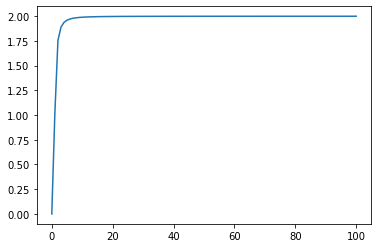

In [4]:
import matplotlib.pyplot as plt

def psi(x, M=1, a=1):
    x = x ** 2

    if x <= M:
        return x

    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a


x = np.linspace(0,100,100)
y = np.linspace(0,100,100)
for i,xx in enumerate(x):
    y[i] = psi(xx)
    
    
plt.plot(x,y)

In [8]:
sig = np.array([1,2,3,4,5,6,6,6,3,3,1])

In [ ]:
def norm(x):
    return np.linalg.norm(x)

def phi(x, order):
    x = np.array(x)

    a = x ** 2
    a[0] -= psi(norm(x))

    f = lambda z: np.dot(a, [z ** (2 * m) for m in range(len(a))])

    return brentq(f, 0, 5)

def get_keys(dim, order):
    s = tosig.sigkeys(dim, order)

    tuples = []

    for t in s.split():
        if len(t) > 2:
            t = t.replace(")", ",)")

        tuples.append(ast.literal_eval(t))

    return tuples

def Phi(X, order, normalise=True, compute_sigs=True):
    if compute_sigs:
        dim = np.shape(X)[1]
        sig = tosig.stream2sig(np.array(X), order)
    else:
        dim = 2
        sig = np.array(X)

    if not normalise:
        return sig

    keys = get_keys(dim, order)

    phi_x = phi(tuple(sig), order)
    Lambda = np.array([phi_x ** len(t) for t in keys])
    return Lambda * sig

def T(set1, set2, order, verbose=True, normalise=True, compute_sigs=True):
    m = len(set1)
    n = len(set2)

    X = Parallel(n_jobs=1)(delayed(Phi)(path, order, normalise, compute_sigs) for path in tqdm(set1, desc="Computing signatures of population 1", disable=(not verbose)))
    Y = Parallel(n_jobs=1)(delayed(Phi)(path, order, normalise, compute_sigs) for path in tqdm(set2, desc="Computing signatures of population 2", disable=(not verbose)))

    XX = np.dot(X, np.transpose(X))
    YY = np.dot(Y, np.transpose(Y))
    XY = np.dot(X, np.transpose(Y))

    TU = 0.
    TU += XX.sum() / (m * m)
    TU += YY.sum() / (n * n)
    TU -= 2 * XY.sum() / (m * n)


    return TU

def c_alpha(m, alpha):
    K = 1.
    return 4 * np.sqrt(-np.log(alpha) / m)
    return (2 * K / m) * (1 + np.sqrt(-2 * np.log(alpha))) ** 2

def test(set1, set2, order, confidence_level=0.99, **kwargs):
    """Statistical test to determine if two sets of paths come
    from the same distribution.

    The statistical test is based in the following paper:

    Chevyrev, I. and Oberhauser, H., 2018. Signature moments to
    characterize laws of stochastic processes. arXiv preprint
    arXiv:1810.10971.


    Parameters
    ----------
    set1 : list of array
        Set of paths.
    set2 : list of array
        Set of paths.
    order : int
        Signature order.
    confidence_level : float, optional
        Confidence level of the statistical test. Must be in [0, 1].
        Default is 0.99, i.e. 99%.

    Returns
    -------
    bool
        True if the hypothesis is rejected and hence the sets come from
        different distributions, False otherwise.

    """

    assert len(set1) == len(set2), "Same size samples accepted for now."

    assert confidence_level >= 0. and confidence_level <= 1., "Confidence level must be in [0, 1]."

    m = len(set1)

    TU = T(set1, set2, order, **kwargs)
    c = c_alpha(m, confidence_level)
    print('c:', c)
    print('TU:', TU)

    return TU > c
